# Neural Network Classification

## 1. Lý thuyết

Trong bài toán phân loại. dữ liệu đầu vào là dữ liệu đã được chuyển sang dạng số và đưa vào một mô hình phân loại. Mô hình phân loại sẽ phân loại ra các nhãn rời rạc dưới dạng xác suất.

Một số tham số cần biết trong một mạng Neural phân loại:
- Input layer shape
- Số lượng Hidden layer
- Output layer shape
- Hidden layer activation (thường là Relu)
- Output activation (sigmoid với binary và softmax với multiclass)
- Loss function và optimizer

## 2. Lập trình với bài toán phân loại nhị phân

### Giả lập dữ liệu

In [133]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42)

X.shape, y.shape

((1000, 2), (1000,))

In [134]:
import pandas as pd

df = pd.DataFrame(X, columns=['x1', 'x2'])
df['y'] = y
df.head()

,x1,x2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


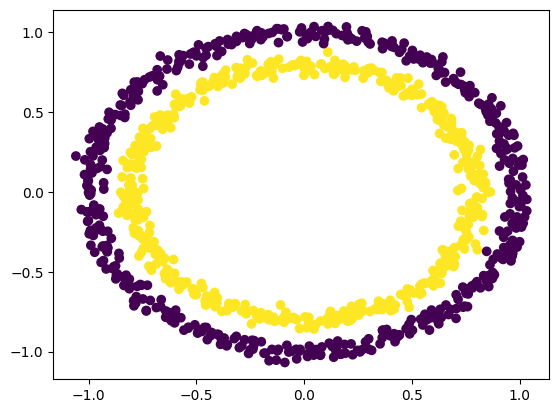

In [135]:
from matplotlib import pyplot as plt

plt.scatter(df['x1'], df['x2'], c=df['y'])
plt.show()

### Chuyển dữ liệu sang dạng tensor

In [136]:
import torch
torch.__version__

'2.5.1+cu124'

In [137]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [138]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### Xây dựng mô hình phân loại

Các bước để xây dựng một mô hình phân loại:
- Xây dựng mô hình thông qua nn.Module
- Xác định một loss function và optimizer
- Tạo training loop và test loop

In [139]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [140]:
class ClassificationNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model = ClassificationNeuralNetwork()
model

ClassificationNeuralNetwork(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)

In [141]:
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997]])),
             ('layer_2.bias', tensor([0.0850]))])

Một cách khác để xây dựng một mô hình mạng neural là sử dụng nn.Sequential như dưới đây

In [142]:
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
    nn.Sigmoid()
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
  (2): Sigmoid()
)

hàm nn.Sequential cũng có thể sử dụng bên trong class như một cách cài đặt mô hình theo từng khối

In [143]:
# Loss và optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [144]:
# Hàm đánh giá mô hình
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### Training

In [145]:
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997]])),
             ('layer_2.bias', tensor([0.0850]))])

In [146]:
# Train and test loop

torch.manual_seed(42)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69989 | Acc: 48.38% | Test Loss: 0.70629 | Test Acc: 49.00%
Epoch: 10 | Loss: 0.69654 | Acc: 49.88% | Test Loss: 0.70242 | Test Acc: 49.00%
Epoch: 20 | Loss: 0.69515 | Acc: 50.38% | Test Loss: 0.70045 | Test Acc: 48.50%
Epoch: 30 | Loss: 0.69440 | Acc: 50.62% | Test Loss: 0.69918 | Test Acc: 48.50%
Epoch: 40 | Loss: 0.69394 | Acc: 51.00% | Test Loss: 0.69827 | Test Acc: 47.50%
Epoch: 50 | Loss: 0.69363 | Acc: 50.88% | Test Loss: 0.69758 | Test Acc: 47.50%
Epoch: 60 | Loss: 0.69343 | Acc: 51.12% | Test Loss: 0.69705 | Test Acc: 47.00%
Epoch: 70 | Loss: 0.69329 | Acc: 51.00% | Test Loss: 0.69664 | Test Acc: 47.50%
Epoch: 80 | Loss: 0.69320 | Acc: 51.25% | Test Loss: 0.69630 | Test Acc: 47.50%
Epoch: 90 | Loss: 0.69313 | Acc: 51.12% | Test Loss: 0.69604 | Test Acc: 47.00%


In [147]:
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5081,  0.5800],
                      [-0.1296,  0.6575],
                      [-0.1889,  0.1351],
                      [-0.3544,  0.4129],
                      [ 0.6427, -0.5143],
                      [ 0.5943,  0.1281],
                      [ 0.5208,  0.0957],
                      [ 0.3098, -0.1066],
                      [ 0.5454,  0.1048],
                      [-0.3185,  0.1826]])),
             ('layer_1.bias',
              tensor([-0.3261, -0.0815, -0.2888,  0.4683, -0.5566, -0.3258, -0.1989, -0.4259,
                       0.0676, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.1992, -0.2677,  0.2647,  0.0849, -0.1697,  0.1117, -0.0229,  0.2169,
                       -0.0425, -0.0577]])),
             ('layer_2.bias', tensor([0.0796]))])

In [148]:
import numpy as np

def plot_predictions_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

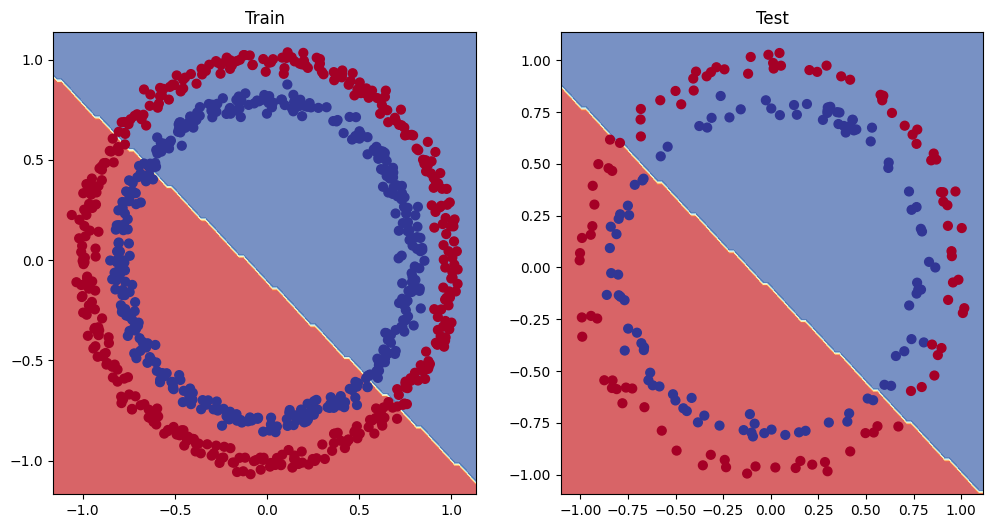

In [149]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_predictions_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_predictions_boundary(model, X_test, y_test)
plt.show()

### Fine tuning

Một số cách phổ biến để cải thiện mô hình:
- Tăng số hidden units
- Thêm các lớp
- Thay đổi/ thêm activation functions
- Thay hàm optimizer
- Điều chỉnh learning rate
- Huấn luyện lâu hơn

In [150]:
model_2 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=1),
)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.01)


In [151]:
# Train and test loop

torch.manual_seed(42)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_2.train()
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295 | Acc: 50.00% | Test Loss: 0.69203 | Test Acc: 55.50%
Epoch: 10 | Loss: 0.68651 | Acc: 53.00% | Test Loss: 0.68401 | Test Acc: 56.50%
Epoch: 20 | Loss: 0.67698 | Acc: 53.50% | Test Loss: 0.67149 | Test Acc: 57.00%
Epoch: 30 | Loss: 0.66078 | Acc: 60.75% | Test Loss: 0.65295 | Test Acc: 62.00%
Epoch: 40 | Loss: 0.63241 | Acc: 66.88% | Test Loss: 0.62340 | Test Acc: 70.00%
Epoch: 50 | Loss: 0.58509 | Acc: 74.25% | Test Loss: 0.57695 | Test Acc: 76.50%
Epoch: 60 | Loss: 0.52041 | Acc: 81.50% | Test Loss: 0.52935 | Test Acc: 81.00%
Epoch: 70 | Loss: 0.43584 | Acc: 90.75% | Test Loss: 0.45495 | Test Acc: 89.00%
Epoch: 80 | Loss: 0.33954 | Acc: 96.50% | Test Loss: 0.35861 | Test Acc: 95.50%
Epoch: 90 | Loss: 0.24768 | Acc: 98.50% | Test Loss: 0.27244 | Test Acc: 97.00%


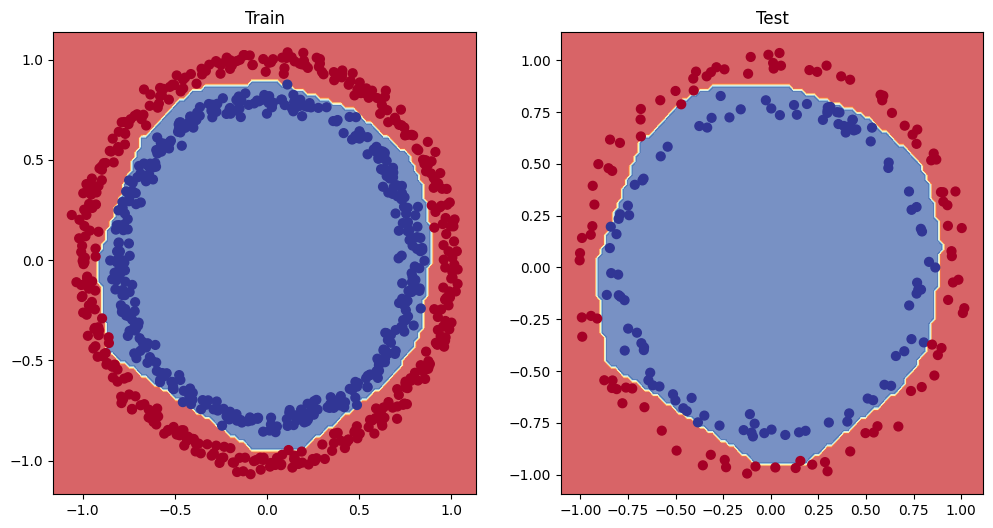

In [152]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_predictions_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_predictions_boundary(model_2, X_test, y_test)
plt.show()

## 3. Lập trình với bài toán phân loại đa nhãn

In [153]:
from sklearn.datasets import make_blobs

# Create data
NUM_CLASSES = 4
NUM_FEATURES = 2

X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state=42)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=42)

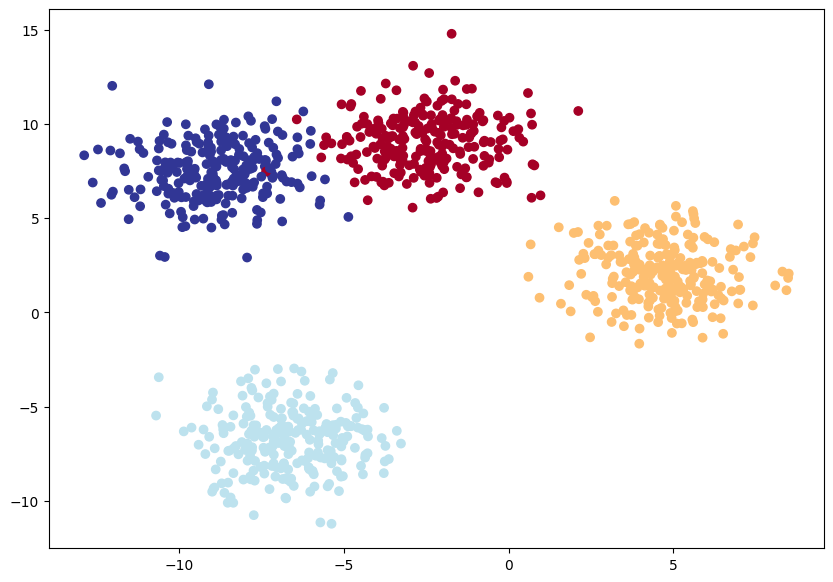

In [154]:
# Visualize
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.show()

In [155]:
class MulticlassClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.Relu = nn.ReLU()
        self.layer2 = nn.Linear(in_features=10, out_features=4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        return self.softmax(self.layer2(self.Relu(self.layer1(x))))

multiclass_model = MulticlassClassification()
multiclass_model

MulticlassClassification(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (Relu): ReLU()
  (layer2): Linear(in_features=10, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [156]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=multiclass_model.parameters(), lr=0.05)

In [157]:
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    multiclass_model.train()
    y_preds = multiclass_model(X_blob_train)
    loss = loss_fn(y_preds, y_blob_train.type(torch.LongTensor))
    acc = accuracy_fn(y_true=y_blob_train, y_pred=torch.argmax(y_preds, dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    multiclass_model.eval()
    with torch.inference_mode():
        test_preds = multiclass_model(X_blob_test)
        test_loss = loss_fn(test_preds, y_blob_test.type(torch.LongTensor))
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=torch.argmax(test_preds, dim=1))

        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.45703 | Acc: 17.12% | Test Loss: 1.44175 | Test Acc: 18.00%
Epoch: 100 | Loss: 0.88276 | Acc: 98.50% | Test Loss: 0.88316 | Test Acc: 99.50%
Epoch: 200 | Loss: 0.78058 | Acc: 99.12% | Test Loss: 0.77842 | Test Acc: 99.50%
Epoch: 300 | Loss: 0.76964 | Acc: 99.12% | Test Loss: 0.76709 | Test Acc: 99.50%
Epoch: 400 | Loss: 0.76513 | Acc: 99.12% | Test Loss: 0.76247 | Test Acc: 99.50%
Epoch: 500 | Loss: 0.76262 | Acc: 99.12% | Test Loss: 0.75991 | Test Acc: 99.50%
Epoch: 600 | Loss: 0.76099 | Acc: 99.12% | Test Loss: 0.75827 | Test Acc: 99.50%
Epoch: 700 | Loss: 0.75984 | Acc: 99.12% | Test Loss: 0.75710 | Test Acc: 99.50%
Epoch: 800 | Loss: 0.75897 | Acc: 99.12% | Test Loss: 0.75622 | Test Acc: 99.50%
Epoch: 900 | Loss: 0.75830 | Acc: 99.12% | Test Loss: 0.75553 | Test Acc: 99.50%


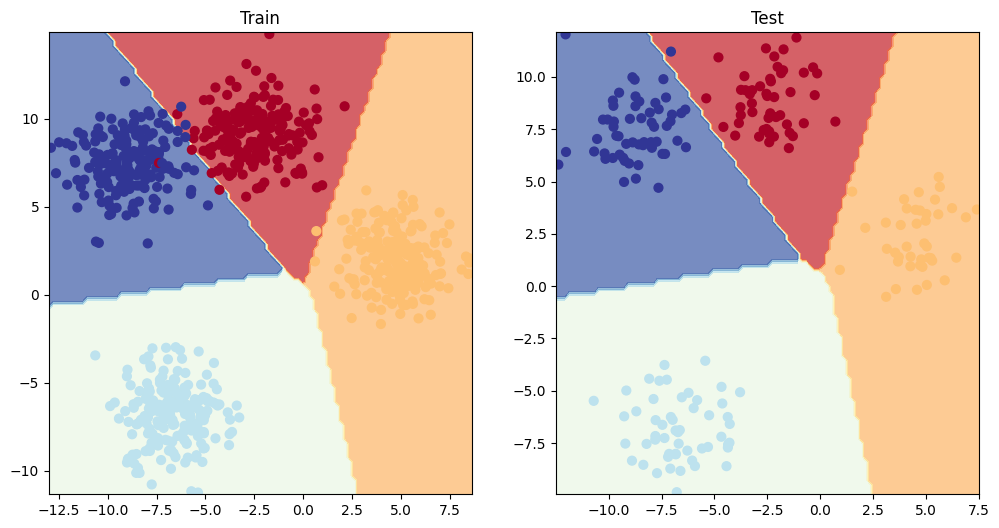

In [158]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_predictions_boundary(multiclass_model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_predictions_boundary(multiclass_model, X_blob_test, y_blob_test)
plt.show()

### Một số metrics đánh giá mô hình phân loại đa nhãn

Accuracy

Recall

Precision

F1-Score

Confusion-matrix

Classification report

In [ ]:
!pip install torchmetrics

In [163]:
from torchmetrics import Accuracy

accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

acc = accuracy(torch.argmax(test_preds, dim=1), y_blob_test.type(torch.LongTensor))
acc

tensor(0.9950)